In [3]:
import numpy as np
import scipy.linalg as la
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

In [152]:
from scipy.integrate import solve_ivp
from scipy.sparse import diags


In [6]:
def gen_args(y):
    print (y, "va fan")
    if y < 10 :
        return 1.
    return 1

def model(t, y):
    arg1 = gen_args(y[0])
    dy_dt = [y[1], -0.5*arg1]
    return dy_dt

In [12]:
tspan = [0,1]
y0 = [1,10]# position 0 have velocity 10

sol = solve_ivp(model, t_span = tspan, y0=y0,t_eval=[0.1])#, events=hit_ground)

print(sol.t)

1.0 va fan
1.0141483232080106 va fan
1.1352753676878014 va fan
1.2028101172654972 va fan
1.5403694937470829 va fan
1.600320181076497 va fan
1.6752331243700658 va fan
1.675233124370065 va fan
3.0234119449723114 va fan
3.687207928652958 va fan
6.9947507063667675 va fan
7.576771462340198 va fan
8.30175582048711 va fan
8.301755820487111 va fan
8.794681084629792 va fan
9.039669323993085 va fan
10.262972306689504 va fan
10.479590858197389 va fan
10.75 va fan
10.75 va fan
[0.1]


In [4]:
def extendvector(F):
    N = F.size
    x = np.arange(N)/N
    width = min(N/2,6)
    

    ca = np.vstack((x[:width]**0, x[:width]**1))
    ca = np.linalg.lstsq(ca.T,F[:width], rcond= None)[0]
    
    cb = np.vstack((x[N-width:]**0, x[N-width:]**1))
    cb = np.linalg.lstsq(cb.T,F[N-width:], rcond= None)[0]
    
    xval = np.hstack([x[:width],x[N-width:]])
    
    fb = cb[0]+cb[1]*(1+x[:width])
    fa = ca[0]+ca[1]*(-x[width:0:-1])
    fval = np.hstack([fb,fa])
    
    F2=interp1d(xval,fval, kind='cubic')
    return np.hstack([F,F2(x)])
    

In [75]:
plab = extendvector(np.arange(20))

(12,) (12,) (20,)


# variable Thermal difussion


\begin{bmatrix}
2-2r & r & 0 & 0 & 0 \\ 
r & 2-2r & r & 0 & 0 \\ 
0 &  r & 2-2r & r & 0 \\ 
0 & 0  & r & 2-2r  & r \\ 
0 & 0 & 0  & r & 2-2r 
\end{bmatrix}

\begin{bmatrix}
U_{1}^{+1}\\ 
U_{2}^{+1}\\ 
U_{3}^{+1}\\ 
U_{4}^{+1}\\ 
U_{5}^{+1}
\end{bmatrix}

= 

\begin{bmatrix}
2+2r & -r & 0 & 0 & 0 \\ 
-r & 2+2r & -r & 0 & 0 \\ 
0 &  -r & 2+2r & -r & 0 \\ 
0 & 0  & -r & 2+2r  & -r \\ 
0 & 0 & 0  & -r & 2+2r 
\end{bmatrix}

\begin{bmatrix}
U_{1}\\ 
U_{2}\\ 
U_{3}\\ 
U_{4}\\ 
U_{5}
\end{bmatrix}

+

\begin{bmatrix}
b_{0}\\ 
0\\ 
0\\ 
0\\ 
b_{6}
\end{bmatrix}

In [168]:

def forwardSolveVariable(Ta, Tb,ic,dtdx, corrector= 15):
    '''
    Ta Temperature for point a
    Tb Temperature for point b
    ic initial condition
    dtdx total time / total length
    corrector maximum itterations for variable kappa
    '''

    
    M = Ta.size
    N = 10
    dt = 1/(M-1)
    dx = 1/(N+1)
    r = dt / dx**2 *dtdx
    print ('M.size', M, beval(ic))
    print (r)
    print ('D', r*beval(ic))
    
    
    b = np.zeros(N)
    U = np.ones([N,M])*ic
    
    avec = beval(U[:,0])
    bvec = np.zeros([2,N])
    bvec[1] = beval(U[:,0])
    
    da = np.zeros(M)
    db = np.zeros(M)
    

    residual = np.zeros((M+1)*corrector)
    
    
    for j in np.arange(M-1)+1:
        D = r*avec
        A = -D*np.eye(N,k=-1) + (2+2*D)*np.eye(N,k=0) - D*np.eye(N,k=1)
        # A = -r * np.diag(avec[2:-1],k=1) + (2+ 2*r) * np.diag(avec[1:-1],k=0) - r* np.diag(avec[2:-1], k = -1)

        
        UU = U[:,j-1]
        
        # boundary condition, these will not change within the corrector loop.
        b[0]  = Ta[j-1] * r * beval(Ta[j-1])
        b[-1] = Tb[j-1] * r * beval(Tb[j-1])
        
        b[0]  = b[0]  + Ta[j]   * r * beval(Ta[j])
        b[-1] = b[-1] + Tb[j]   * r * beval(Tb[j])
        
        i = 1
        
        while(i<corrector):
            bvec[0] = bvec[1]
            
            B = +r*bvec[0] * np.eye(N, k=-1) + (2-2*r*bvec[0])*np.eye(N, k=0) + r*bvec[0]*np.eye(N, k=1)

            
            Utmp = B.dot(UU)
        
        
            Utmp = Utmp + b
            U[:,j] = np.linalg.lstsq(A,Utmp,rcond= None)[0]
            bvec[1] = beval(U[:,j])
            residual[ j * corrector + i ] = abs(bvec[0].mean() - bvec[1].mean())
            i = i+1 # add while residual < tolerance
        
        
        avec = bvec[0].copy()  # sett kappa values for t-1 in the next itteration
        
        # the derivatives on the points Ta and Tb
        
        da[j] = (-147*U[0,j]+360*U[1,j]-450*U[2,j]+400*U[3,j]-225*U[4,j]+72*U[5,j]-10*U[6,j])/(60*1.0*dx**1)
        db[j] = (10*U[-7,j]-72*U[-6,j]+225*U[-5,j]-400*U[-4,j]+450*U[-3,j]-360*U[-2,j]+147*U[-1,j])/(60*1.0*dx**1)
    return U, da ,db, residual
    
    

In [225]:
def beval(T):
    cp = 475
    #k = 44.5 
    k =  2.73741657e-08*(T-273)**3 -2.16750919e-05*(T-273)**2 -4.33713138e-02*(T-273)**1 + 2*6.50693381e+03*(T-273)**0
    
    rho = 7850
    a = k/(cp*rho)
    val = T**0*a
    return val

In [226]:
 
time = 1.5                   #  Total time
dx = 0.001                   #  Total length 

ta = x['ColledVariable'].values    # Temperature in point a
tb = x['measureVariable'].values   # Temperature in point b
dtdx = 1.5/dx**2             

#dtdx = time/dx**2            # scale factor


sol,da,db, residual= forwardSolveVariable(ta, tb, 1123.15, dtdx)

M.size 3003 0.003480563131651593
60459.69353764157
D 210.43378027806935


In [178]:
x = pd.read_csv('dataPointsVariable.csv')
print (x.shape)
x = x.reindex(x.index.union(np.linspace(0,1501,3003)))
x.interpolate('index', inplace = True)
xx = pd.read_csv('CrossS.csv', header = None, index_col = 0)



(1501, 5)


In [143]:
np.linspace(0,1501,3003)

array([0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 1.5000e+03, 1.5005e+03,
       1.5010e+03])

In [170]:
1500*0.7/1.5

700.0

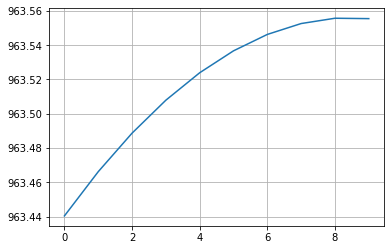

In [227]:
plt.plot(sol[:,700])
plt.grid()

[507.7323386  507.74873154 507.76303082 507.77534397 507.78570139
 507.79411121 507.80057312 507.80507834 507.80759587 507.80801773]
507.7135555443036 507.80604761773714


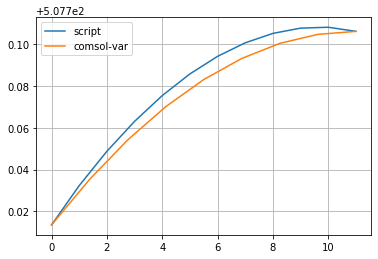

In [228]:
i = 1400
plt.plot(np.concatenate((ta[i],sol[:,i], tb[i]), axis = None))
plt.plot(11-xx.index*11/8,xx[1])
#lt.plot(11-xx.index*11/8,xx[2])
print(sol[:,i])
print (ta[i], tb[i])
#plt.ylim([400,1150])
plt.legend(['script','comsol-var', 'comsol-const'])
plt.grid()

0.0


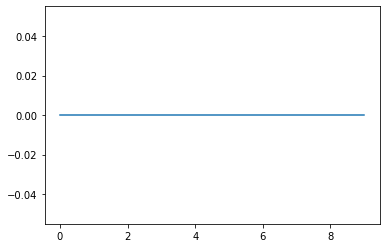

In [45]:
plt.plot(residual[405:415])
print (residual[409])

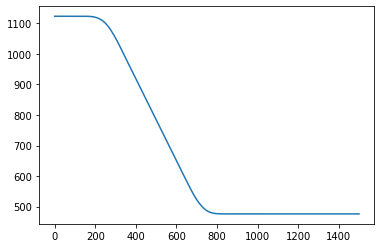

In [131]:
plt.plot(tb)

In [22]:
d = 1.5/0.001**2

In [23]:
dd = (1/1500)/(1/10)**2

In [24]:
d*dd

99999.99999999997

In [229]:
(1.5/2000)/(0.0001)**2

75000.0

In [19]:
0.001/0.0001**2

100000.0

In [77]:
aa = np.arange(9).reshape(3,3)
aa

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [79]:
aa[0,0] = 3
aa

array([[3, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [80]:
aa[-1,-1] = aa[-1,-1]/2 

In [ ]:
aa

In [231]:
2.73741657e-08*(600-273)**3 -2.16750919e-05*(600-273)**2 -4.33713138e-02*(600-273)**1 + 6.50693381e+01*(600-273)**0

49.52638172329714

In [ ]:
2